# Cardiovascular Disease XGBoost Classification

Uses an XGBoost model to perform classification to detect the presence of cardiovascular disease in a person based on the given features.
Trains an XGBoost model locally using SciKitLearn, performs hyperparameter tuning locally before finally training and deploying a SageMaker XGBoost model.

Data Source: https://www.kaggle.com/sulianova/cardiovascular-disease-dataset

Features:
- Age | Objective Feature | age | int (days)
- Height | Objective Feature | height | int (cm) |
- Weight | Objective Feature | weight | float (kg) |
- Gender | Objective Feature | gender | categorical code |
- Systolic blood pressure | Examination Feature | ap_hi | int |
- Diastolic blood pressure | Examination Feature | ap_lo | int |
- Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
- Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
- Smoking | Subjective Feature | smoke | binary |
- Alcohol intake | Subjective Feature | alco | binary |
- Physical activity | Subjective Feature | active | binary |
- Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

Tasks:
- 1. Load the Dataset 
- 2. Perform Exploratory Data Analysis
- 3. Perform Data Visualisation
- 4. Create Training and Testing Datasets
- 5. Train an XG-Boost classifier model (locally not using SageMaker)
- 6. Perform GridSearch Hyperparameter Optimisation
- 7. Train an XG-Boost classifier model (using Amazon SageMaker)
- 8. Deploy trained model as an endpoint
- 9. Assess trained model performance
- 10. Delete the endpoint

## Import dependencies

In [2]:
!pip install xgboost

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
import sagemaker
import boto3
from sagemaker import Session
import os
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt

%matplotlib inline

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/8c/3a/c9c5d4d5c49b132ef15ac7b5ccf56ef1c82efe36cd19414771762e97c00e/xgboost-1.7.6-py3-none-manylinux2014_x86_64.whl.metadata
  Using cached xgboost-1.7.6-py3-none-manylinux2014_x86_64.whl.metadata (1.9 kB)
  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/10/be/ae5bf4737cb79ba437879915791f6f26d92583c738d7d960ad94e5c36adf/numpy-1.24.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached numpy-1.24.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached xgboost-1.7.6-py3-none-manylinux2014_x86_64.whl (200.3 MB)
Using cached numpy-1.24.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.1
    Uninstalling numpy-1.25.1:
      Successfully uninstalled numpy-1.25.1
ERROR: pip's dependency resolver does not 

## 1. Load the Dataset

In [3]:
# import the csv files using pandas 
# note the seperator is ';' instead of ','
cardio_df = pd.read_csv("cardio_train.csv", sep=";")
cardio_df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


## 2. Perform Exploratory Data Analysis

In [4]:
# view first 5 rows
cardio_df.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [5]:
# view last 5 rows
cardio_df.tail(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1
69999,99999,20540,1,170,72.0,120,80,2,1,0,0,1,0


In [6]:
# show general descriptive statistics
cardio_df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
# show column data type info
cardio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [8]:
# show count unique entries for each column
cardio_df.nunique()

id             70000
age             8076
gender             2
height           109
weight           287
ap_hi            153
ap_lo            157
cholesterol        3
gluc               3
smoke              2
alco               2
active             2
cardio             2
dtype: int64

NOTE:
- The dataset appears to have several non-ordinal categorical values (eg. gender) that have been represented numerically.

## 3. Perform Data Visualisation

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'gender'}>,
        <AxesSubplot:title={'center':'height'}>],
       [<AxesSubplot:title={'center':'weight'}>,
        <AxesSubplot:title={'center':'ap_hi'}>,
        <AxesSubplot:title={'center':'ap_lo'}>,
        <AxesSubplot:title={'center':'cholesterol'}>],
       [<AxesSubplot:title={'center':'gluc'}>,
        <AxesSubplot:title={'center':'smoke'}>,
        <AxesSubplot:title={'center':'alco'}>,
        <AxesSubplot:title={'center':'active'}>],
       [<AxesSubplot:title={'center':'cardio'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

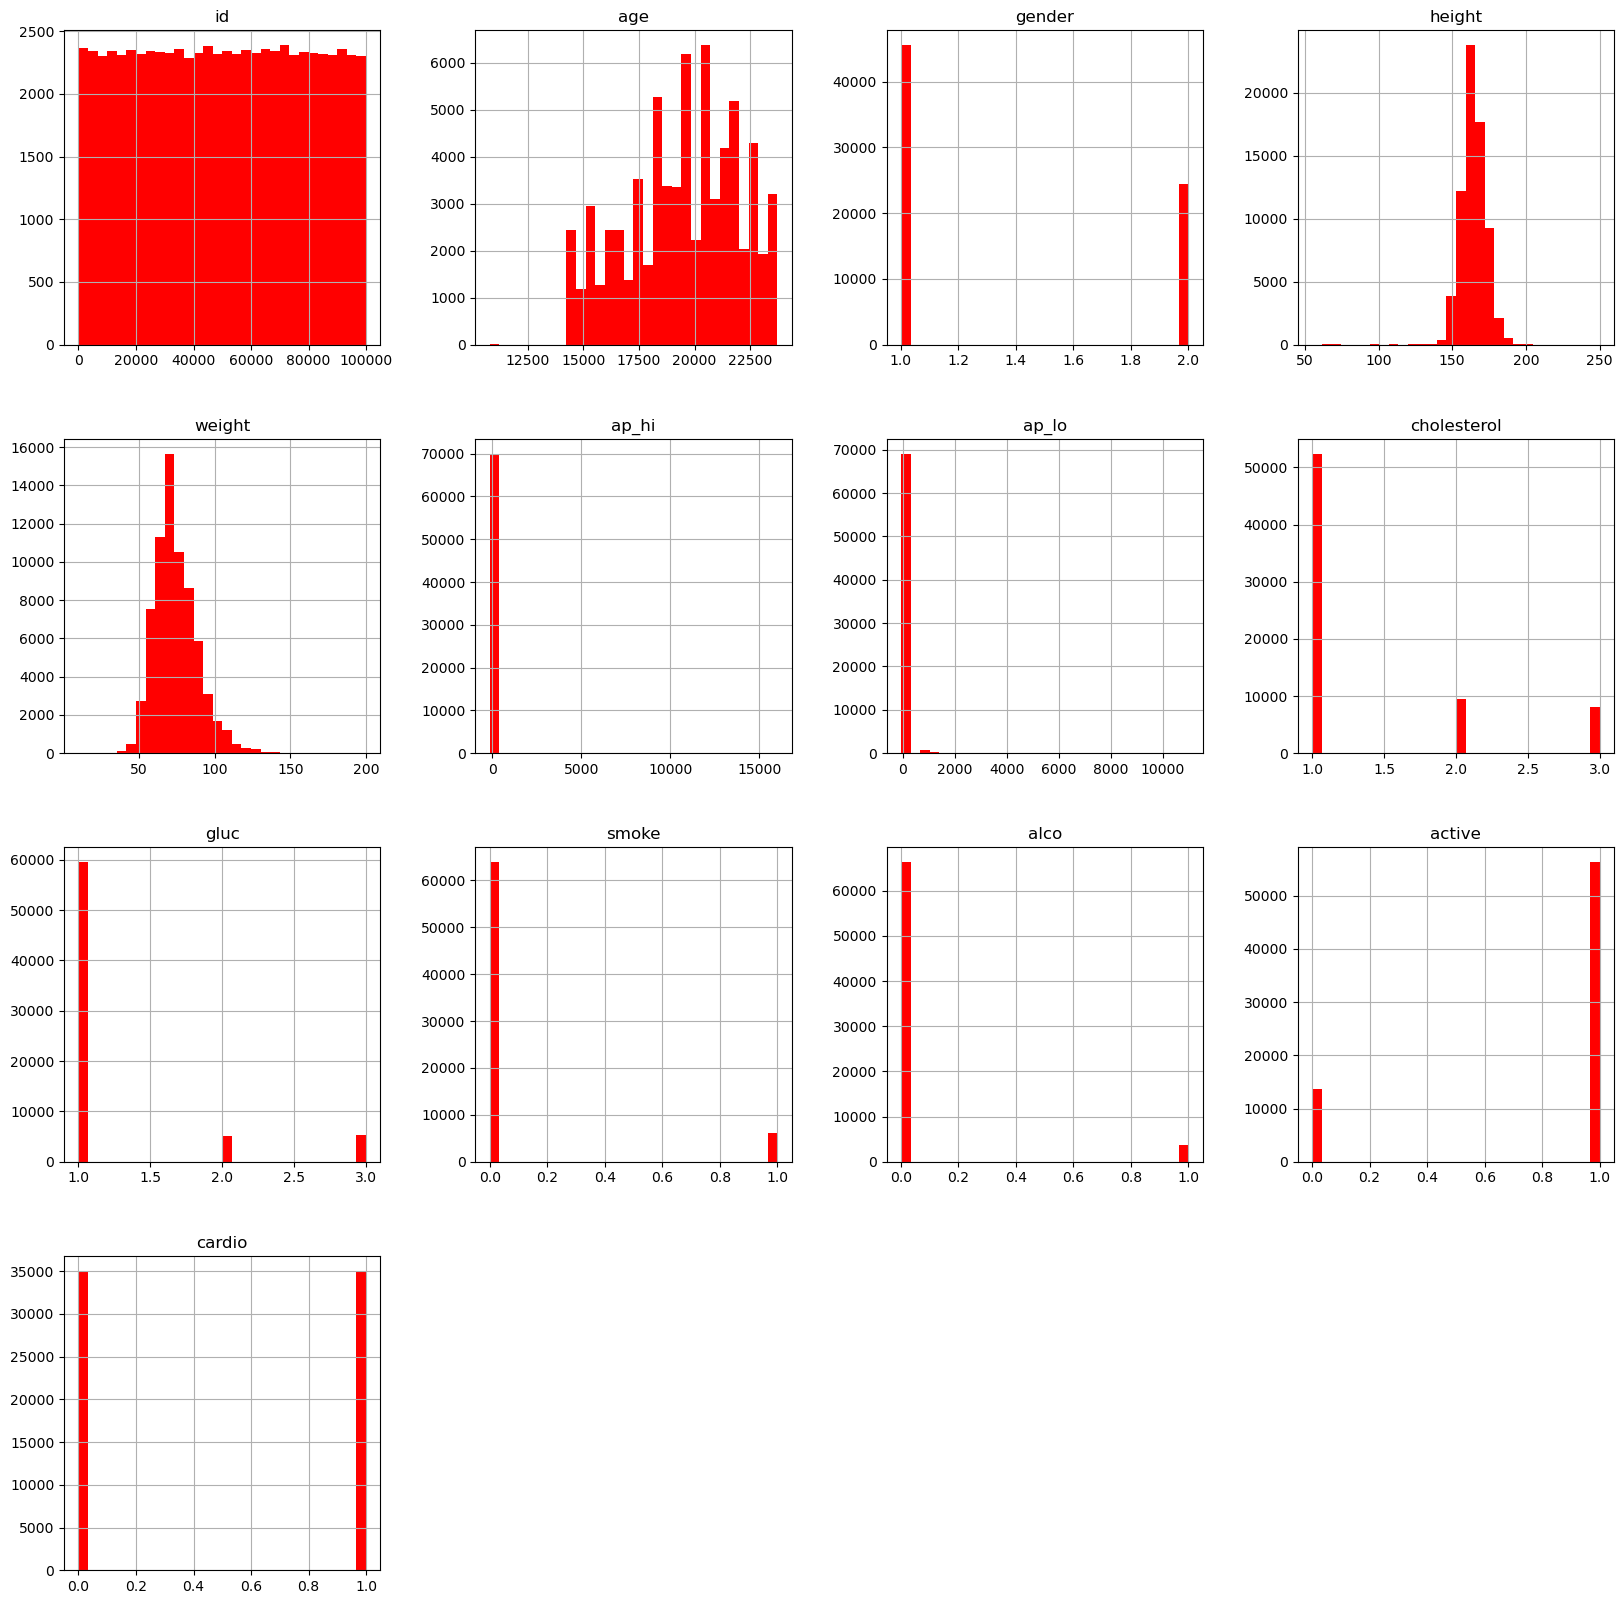

In [9]:
# plot data on histograms
cardio_df.hist(bins = 30, figsize = (20,20), color = 'r')

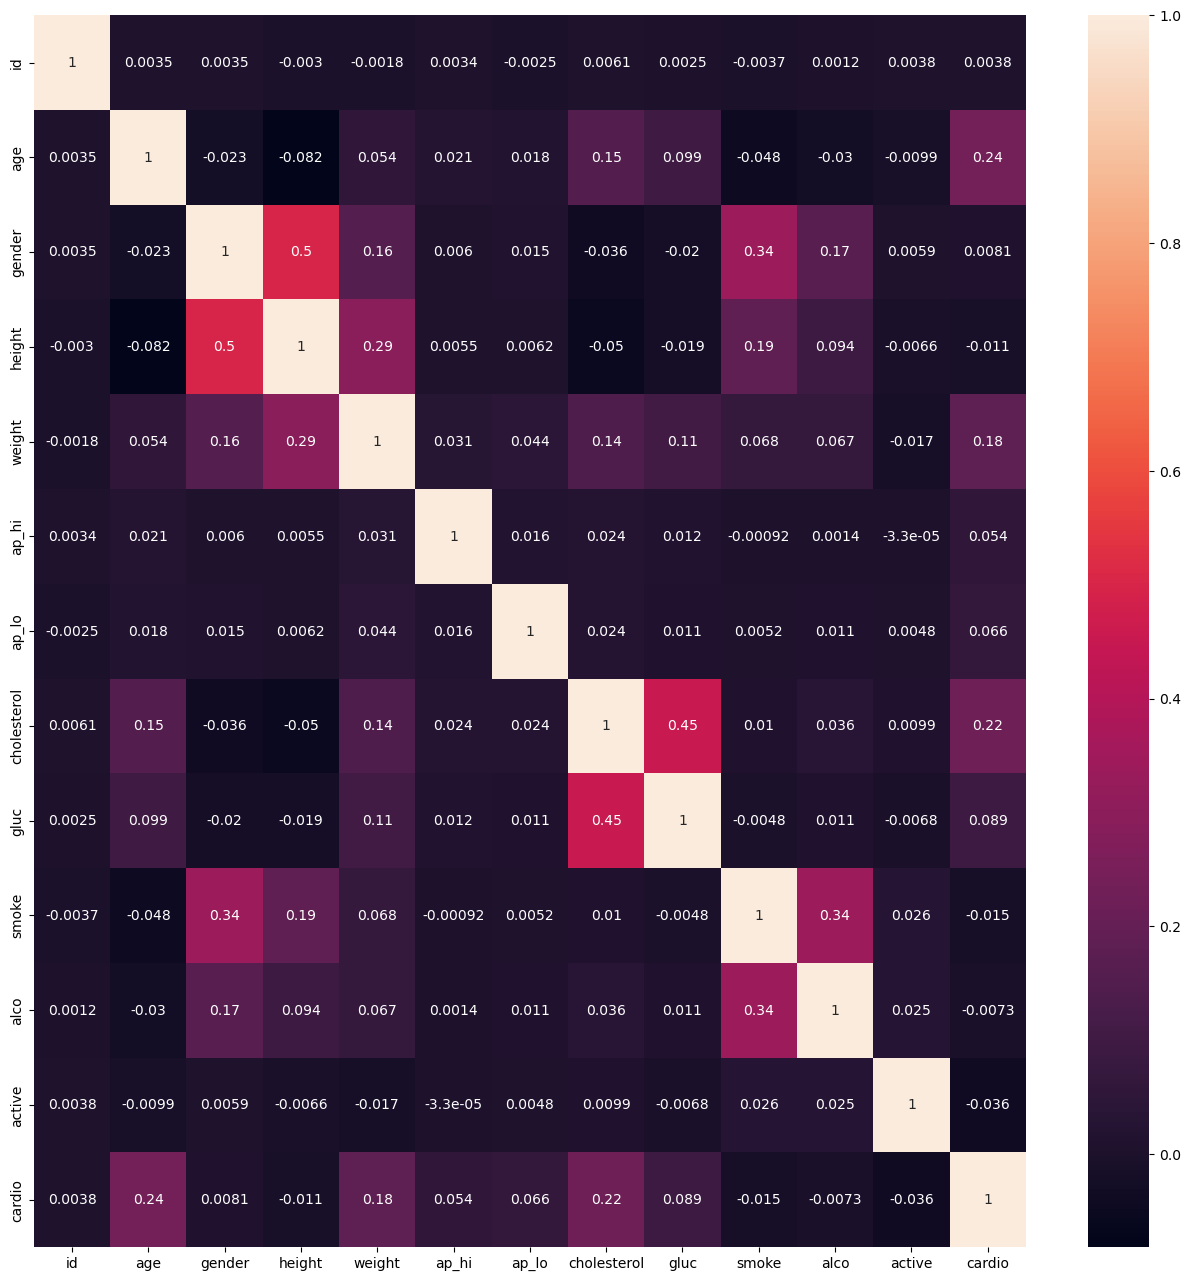

In [10]:
# generate a heatmap for all data values
plt.figure(figsize = (16, 16))
sns.heatmap(cardio_df.corr(), annot = True);

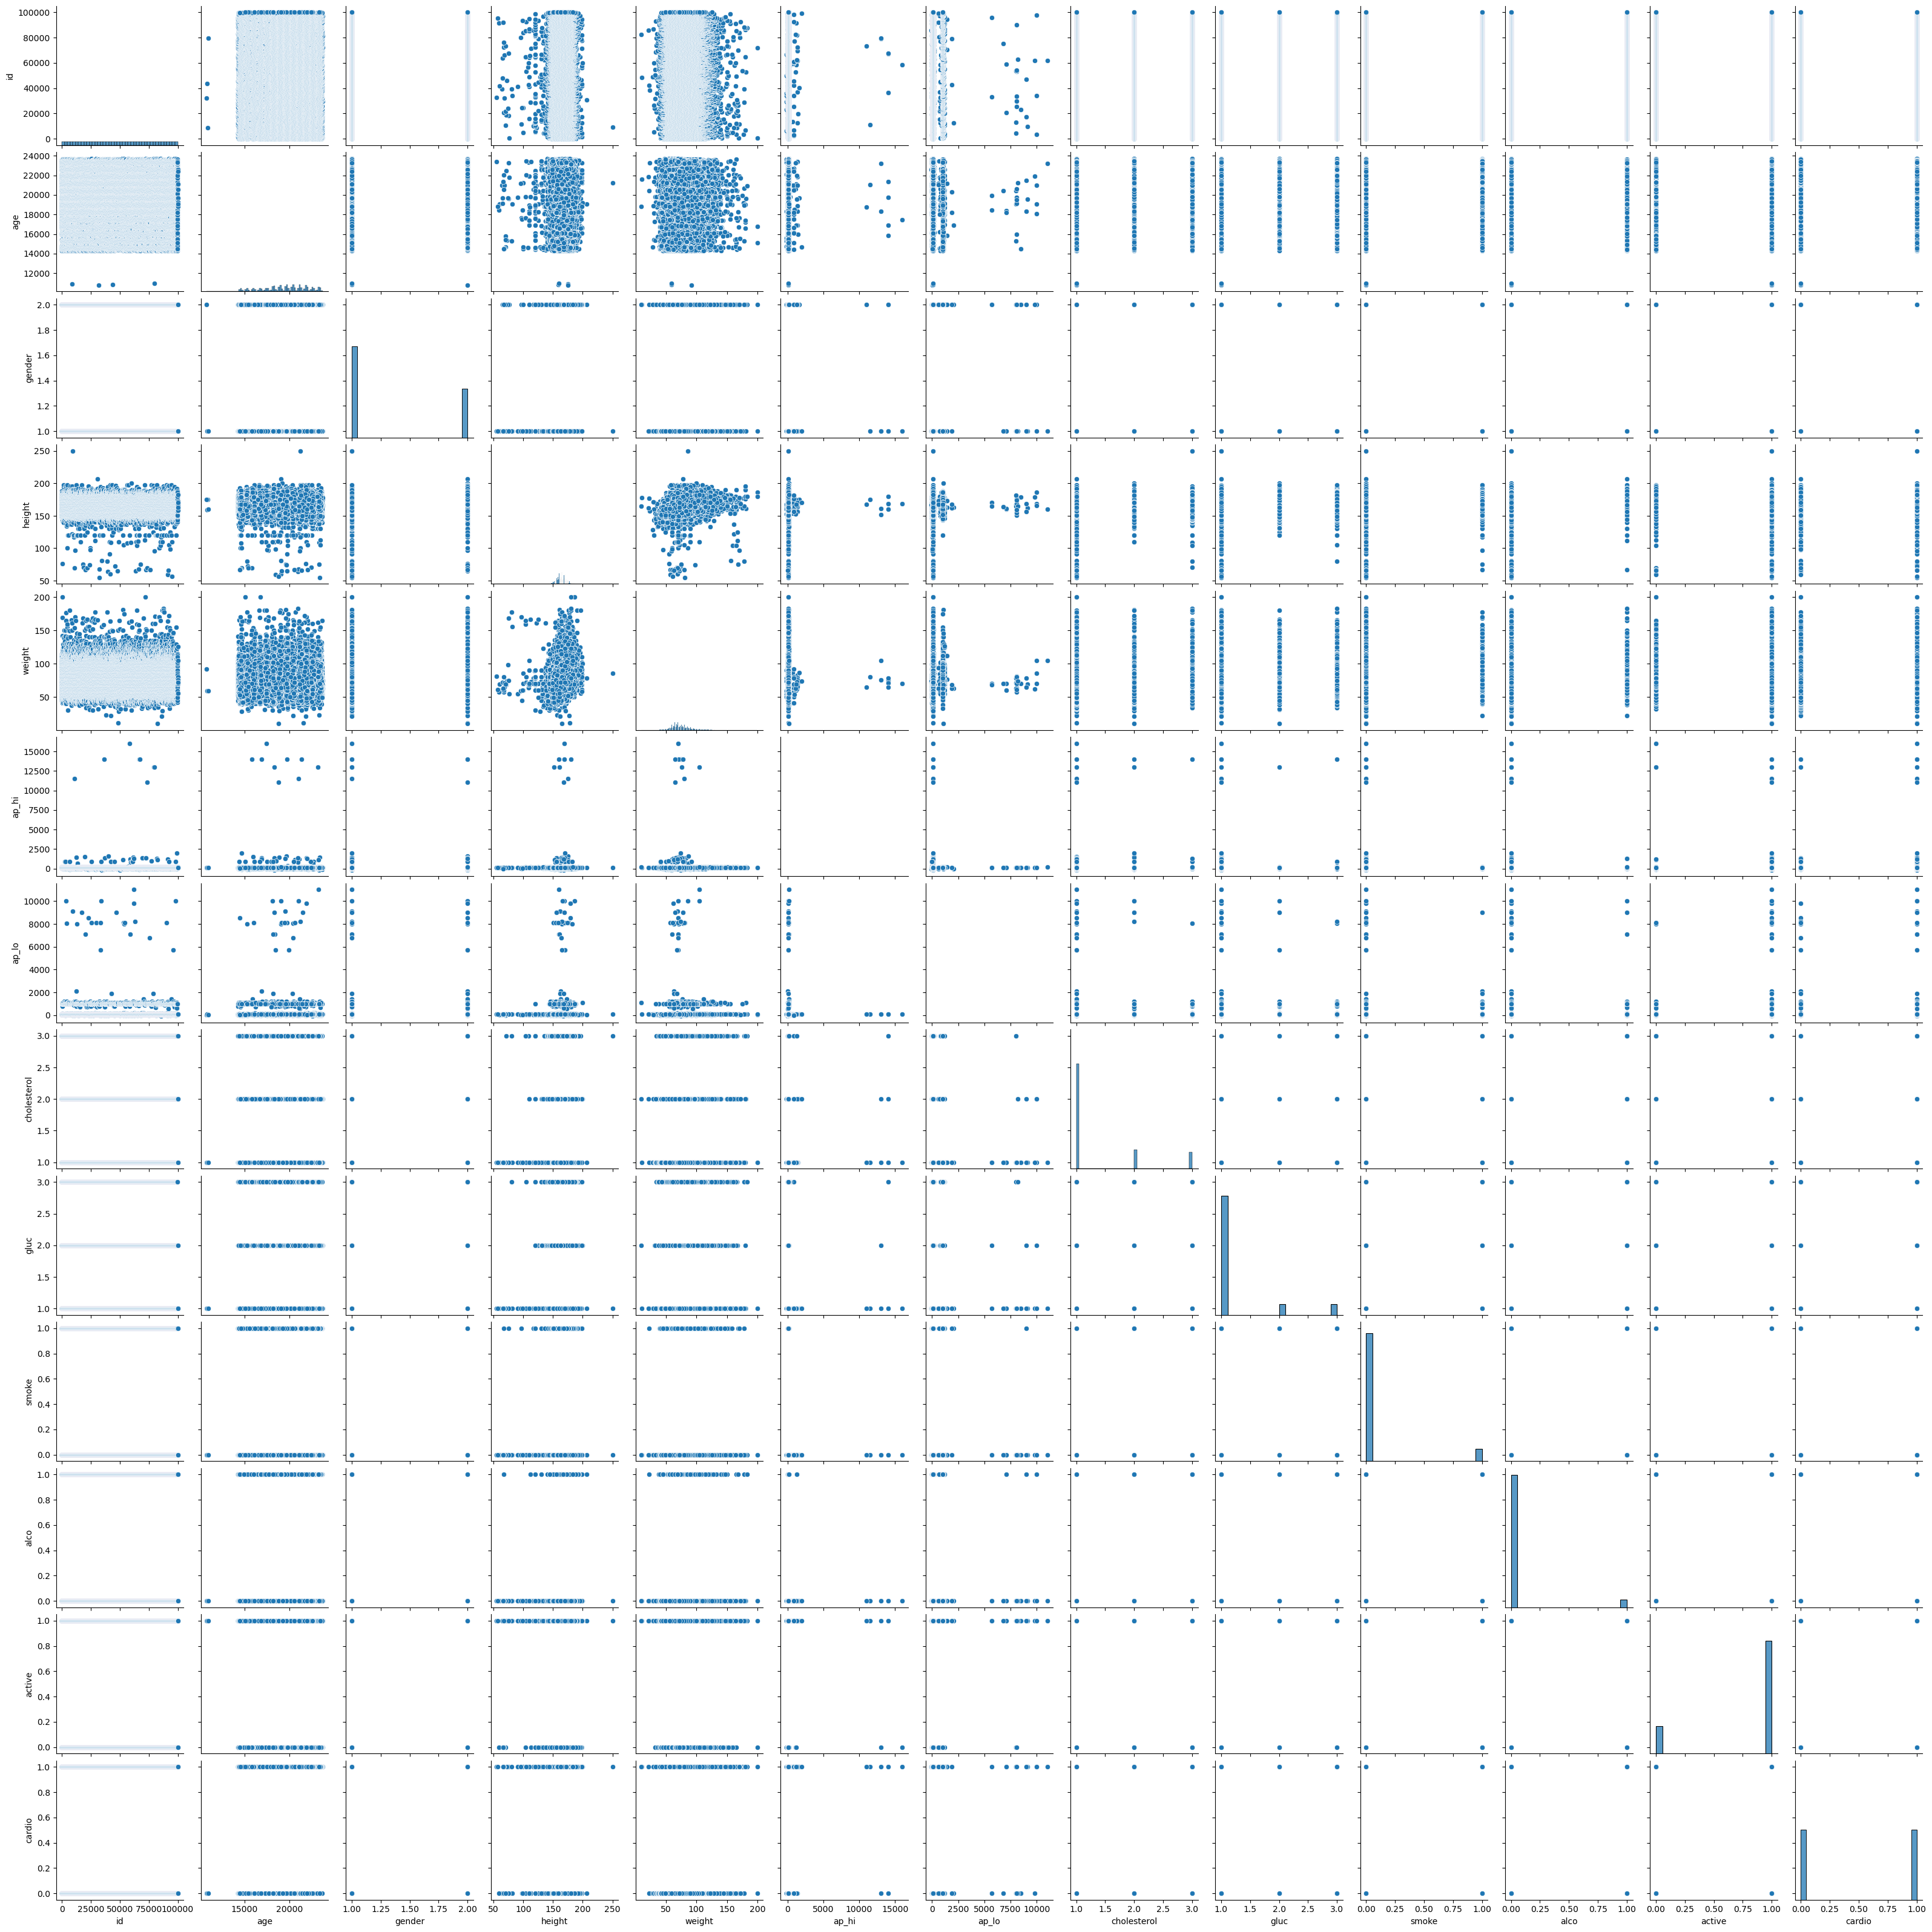

In [11]:
# generate pairplot for data
sns.pairplot(cardio_df);

## 4. Create Training and Testing Datasets

In [12]:
# split the dataframe into target and features
target_df = cardio_df['cardio']
features_df = cardio_df.drop(columns =['cardio'])

In [13]:
# create training and test datasets
X_train, X_test, y_train, y_test = train_test_split(features_df, target_df, test_size = 0.2)

In [14]:
print("X_train: {}".format(X_train.shape))
print("X_test: {}".format(X_test.shape))
print("y_train: {}".format(y_train.shape))
print("y_test: {}".format(y_test.shape))

X_train: (56000, 12)
X_test: (14000, 12)
y_train: (56000,)
y_test: (14000,)


## 5. Train an XG-Boost classifier model (locally not using SageMaker)

In [15]:
# train XG-Boost Model
model = XGBClassifier(learning_rate=0.01, n_estimators=100, objective='binary:logistic')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [16]:
# make predictions using test data
y_predict = model.predict(X_test)
y_predict

array([1, 0, 1, ..., 0, 1, 1])

In [17]:
# print metrics for testing dataset
print("Precision: {}".format(precision_score(y_test, y_predict)))
print("Recall: {}".format(recall_score(y_test, y_predict)))
print("Accuracy: {}".format(accuracy_score(y_test, y_predict)))

Precision: 0.764687151727432
Recall: 0.6902845645300374
Accuracy: 0.7405


<AxesSubplot:>

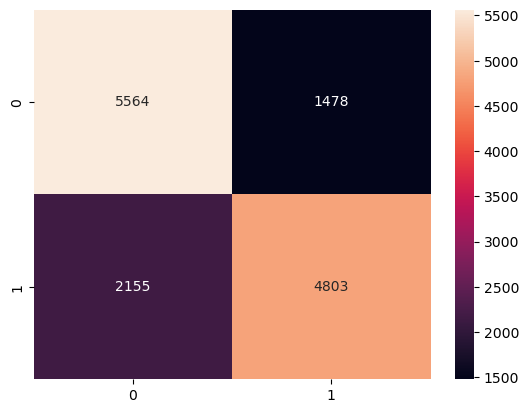

In [18]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_predict)
plt.figure()
sns.heatmap(cm, annot = True, fmt='2')

NOTE:
- We have not performed data normalization or scaling as XGBoost is not sensitive to this.

## 6. Perform GridSearch Hyperparameter Optimisation

In [19]:
grid_params = {
    'learning_rate': [0.01, 0.5, 1],
    'max_depth': [3, 4, 5]
}

In [21]:
xgb_model = XGBClassifier(learning_rate = 0.01, objective='binary:logistic')
grid = GridSearchCV(xgb_model, grid_params, refit = True, verbose = 4)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ...learning_rate=0.01, max_depth=3;, score=0.722 total time=   2.2s
[CV 2/5] END ...learning_rate=0.01, max_depth=3;, score=0.727 total time=   2.0s
[CV 3/5] END ...learning_rate=0.01, max_depth=3;, score=0.721 total time=   2.2s
[CV 4/5] END ...learning_rate=0.01, max_depth=3;, score=0.721 total time=   2.3s
[CV 5/5] END ...learning_rate=0.01, max_depth=3;, score=0.723 total time=   2.2s
[CV 1/5] END ...learning_rate=0.01, max_depth=4;, score=0.732 total time=   3.1s
[CV 2/5] END ...learning_rate=0.01, max_depth=4;, score=0.732 total time=   2.9s
[CV 3/5] END ...learning_rate=0.01, max_depth=4;, score=0.728 total time=   2.9s
[CV 4/5] END ...learning_rate=0.01, max_depth=4;, score=0.730 total time=   3.0s
[CV 5/5] END ...learning_rate=0.01, max_depth=4;, score=0.731 total time=   2.9s
[CV 1/5] END ...learning_rate=0.01, max_depth=5;, score=0.732 total time=   3.8s
[CV 2/5] END ...learning_rate=0.01, max_depth=5;,

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.01, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_c

In [22]:
# make predictions using test data
y_predict = grid.predict(X_test)
y_predict

array([1, 0, 1, ..., 0, 1, 1])

In [23]:
# print metrics for testing dataset
print("Precision: " + str(precision_score(y_test, y_predict)))
print("Recall: " + str(recall_score(y_test, y_predict)))
print("Accuracy: " + str(accuracy_score(y_test, y_predict)))

Precision: 0.7511902933497159
Recall: 0.7029318769761426
Accuracy: 0.7366428571428572


<AxesSubplot:>

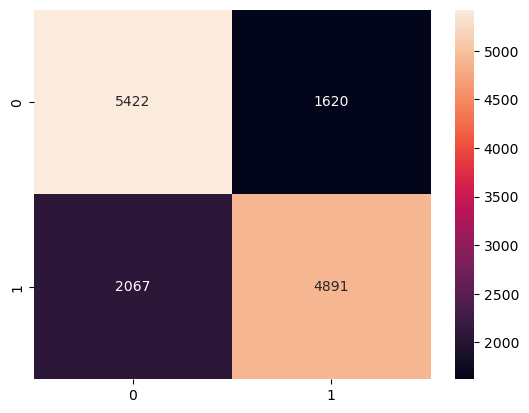

In [24]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_predict)
plt.figure()
sns.heatmap(cm, annot = True, fmt='2')

In [25]:
# print best params
print("GridSearchCV Best Params: {}".format(grid.best_params_))

GridSearchCV Best Params: {'learning_rate': 0.5, 'max_depth': 3}


## 7. Train a XG-Boost classifier model (using Amazon SageMaker)

In [26]:
# split the dataframe into target and features
target_df = cardio_df['cardio']
features_df = cardio_df.drop(columns =['cardio'])

In [27]:
# convert to numpy array (for sagemaker)
X = np.array(features_df)
y = np.array(target_df)

print("X: " + str(X.shape))
print("y: " + str(y.shape))

X: (70000, 12)
y: (70000,)


In [28]:
# reshaping the y array (for sagemaker)
y = y.reshape(-1,1)
print("y: " + str(y.shape))

y: (70000, 1)


In [30]:
# spliting the data into training, testing and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5)

print("X_train: " + str(X_train.shape))
print("y_train: " + str(y_train.shape))
print("X_test: " + str(X_test.shape))
print("y_test: " + str(y_test.shape))
print("X_val: " + str(X_val.shape))
print("y_val: " + str(X_val.shape))

X_train: (49000, 12)
y_train: (49000, 1)
X_test: (10500, 12)
y_test: (10500, 1)
X_val: (10500, 12)
y_val: (10500, 12)


In [31]:
# convert training data and validation into a dataframe with the first column as the target (for sagemaker)
train_data = pd.DataFrame({'Target': y_train[:,0]})
for i in range(X_train.shape[1]):
    train_data[i] = X_train[:,i]

val_data = pd.DataFrame({'Target': y_val[:,0]})
for i in range(X_val.shape[1]):
    val_data[i] = X_val[:,i]

In [32]:
train_data

,Target,0,1,2,3,4,5,6,7,8,9,10,11
0,0,71049.0,20271.0,1.0,167.0,117.0,140.0,100.0,3.0,3.0,0.0,0.0,1.0
1,1,51359.0,21317.0,1.0,165.0,65.0,120.0,80.0,1.0,1.0,0.0,0.0,1.0
2,1,82740.0,22639.0,1.0,165.0,84.0,110.0,70.0,3.0,1.0,0.0,0.0,1.0
3,1,844.0,19669.0,1.0,150.0,65.0,120.0,80.0,2.0,3.0,0.0,0.0,1.0
4,1,2293.0,20219.0,1.0,154.0,50.0,110.0,70.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48995,1,20684.0,19649.0,1.0,164.0,66.0,120.0,80.0,2.0,1.0,0.0,0.0,1.0
48996,0,77681.0,14518.0,1.0,166.0,87.0,130.0,80.0,1.0,1.0,0.0,0.0,1.0
48997,1,15623.0,22420.0,1.0,164.0,61.0,170.0,1000.0,3.0,3.0,0.0,0.0,1.0
48998,0,95908.0,18179.0,1.0,148.0,67.0,130.0,80.0,1.0,2.0,0.0,0.0,1.0


In [33]:
val_data

,Target,0,1,2,3,4,5,6,7,8,9,10,11
0,0,2457.0,20503.0,2.0,175.0,71.0,120.0,80.0,3.0,3.0,0.0,0.0,1.0
1,1,47410.0,22375.0,2.0,160.0,92.0,140.0,90.0,3.0,3.0,0.0,0.0,0.0
2,0,87972.0,18503.0,1.0,159.0,61.0,120.0,80.0,1.0,1.0,0.0,0.0,1.0
3,0,98892.0,16807.0,2.0,177.0,81.0,120.0,80.0,1.0,1.0,1.0,1.0,1.0
4,1,12810.0,18329.0,2.0,168.0,63.0,130.0,80.0,3.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10495,0,50666.0,15311.0,2.0,178.0,84.0,120.0,80.0,1.0,1.0,0.0,0.0,1.0
10496,0,55732.0,15352.0,2.0,168.0,70.0,110.0,70.0,1.0,1.0,1.0,0.0,1.0
10497,0,57576.0,16117.0,1.0,169.0,61.0,110.0,70.0,1.0,1.0,0.0,0.0,1.0
10498,1,67723.0,19045.0,1.0,178.0,85.0,120.0,80.0,1.0,1.0,0.0,0.0,0.0


In [34]:
# save train_data and validation_data as csv files.
train_data.to_csv('train.csv', header = False, index = False)
val_data.to_csv('validation.csv', header = False, index = False)

In [35]:
# create a Sagemaker session
sagemaker_session = sagemaker.Session()
bucket = Session().default_bucket() 
prefix = 'XGBoost-Regressor'
key = 'XGBoost-Regressor'

# declare role to give learning and hosting access to the data
role = sagemaker.get_execution_role()
role

'arn:aws:iam::628298263648:role/AmazonSageMaker-ExecutionRole-SageMaker-S3-FullAccess'

In [36]:
# upload the training data csv to the s3 bucket
with open('train.csv','rb') as f:
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(f)

s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://sagemaker-us-east-1-628298263648/XGBoost-Regressor/train/XGBoost-Regressor


In [37]:
# upload the validation data csv to the s3 bucket
with open('validation.csv','rb') as f:
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation', key)).upload_fileobj(f)

s3_validation_data = 's3://{}/{}/validation/{}'.format(bucket, prefix, key)
print('uploaded validation data location: {}'.format(s3_validation_data))

uploaded validation data location: s3://sagemaker-us-east-1-628298263648/XGBoost-Regressor/validation/XGBoost-Regressor


In [38]:
# creates output placeholder in S3 bucket to store the trained model
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

training artifacts will be uploaded to: s3://sagemaker-us-east-1-628298263648/XGBoost-Regressor/output


In [39]:
# create a reference to the XGBoost container image
container = sagemaker.image_uris.retrieve("xgboost", boto3.Session().region_name, version='1.0-1')
container

'683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3'

In [46]:
# create a SageMaker XGBoost classifier
classifier = sagemaker.estimator.Estimator(container,
                                       role, 
                                       instance_count = 1, 
                                       instance_type = 'ml.m4.xlarge',
                                       output_path = output_location,
                                       sagemaker_session = sagemaker_session)

# set the classifier hyperparameters
classifier.set_hyperparameters(max_depth = 3, # value from gridsearch best params
                               learning_rate = 0.5, # value from gridsearch best params
                               objective = 'multi:softmax',
                               num_class = 2,
                               eta = 0.5,
                               num_round = 150)

In [47]:
# define the regressor data channels (training and validation data)
train_input = sagemaker.session.TrainingInput(s3_data = s3_train_data, content_type = 'csv',s3_data_type = 'S3Prefix')
valid_input = sagemaker.session.TrainingInput(s3_data = s3_validation_data, content_type = 'csv',s3_data_type = 'S3Prefix')

data_channels = {'train': train_input,'validation': valid_input}

In [48]:
# train the data model using the data channels
classifier.fit(data_channels)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-08-20-14-15-50-473


2023-08-20 14:15:50 Starting - Starting the training job...
2023-08-20 14:16:16 Starting - Preparing the instances for training......
2023-08-20 14:17:21 Downloading - Downloading input data......
2023-08-20 14:17:52 Training - Downloading the training image...
2023-08-20 14:18:42 Training - Training image download completed. Training in progress..[2023-08-20 14:18:52.768 ip-10-2-67-79.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value multi:softmax to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined deli

## 8. Deploy trained model as an endpoint

In [56]:
# deploy the model
predictor = classifier.deploy(initial_instance_count = 1, instance_type = "ml.m4.xlarge")

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-08-20-14-37-33-096
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-08-20-14-37-33-096
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-08-20-14-37-33-096


----------!

## 9. Assess trained model performance

In [57]:
# obtain predictions for test data
predictor.serializer = CSVSerializer()
predictions = predictor.predict(X_test)
predictions

b'1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.

In [58]:
# convert the values in bytes format to array
def bytes_2_array(x):
    l = str(x).split(',')
    l[0] = l[0][2:]
    l[-1] = l[-1][:-1]
    for i in range(len(l)):
        l[i] = float(l[i])
    l = np.array(l).astype('float32')
    return l.reshape(-1,1)
    
predicted_values = bytes_2_array(predictions)
predicted_values

array([[1.],
       [0.],
       [1.],
       ...,
       [0.],
       [1.],
       [0.]], dtype=float32)

In [59]:
# collect KPI metrics by comparing predicted_values for test data to actual y_test values
k = X_test.shape[1]
n = len(X_test)
RMSE = float(format(np.sqrt(mean_squared_error(y_test, predicted_values)),'.3f'))
MSE = mean_squared_error(y_test, predicted_values)
MAE = mean_absolute_error(y_test, predicted_values)
r2 = r2_score(y_test, predicted_values)
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)

print('RMSE =',RMSE, '\nMSE =',MSE, '\nMAE =',MAE, '\nR2 =', r2, '\nAdjusted R2 =', adj_r2) 

RMSE = 0.52 
MSE = 0.2704761904761905 
MAE = 0.2704761904761905 
R2 = -0.08194009056078033 
Adjusted R2 = -0.08317812632760879


<AxesSubplot:>

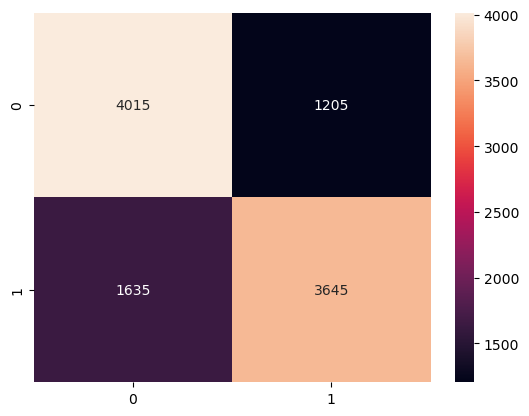

In [60]:
# plot confusion matrix
cm = confusion_matrix(y_test, predicted_values)
plt.figure()
sns.heatmap(cm, annot=True, fmt = 'd')

## 10. Delete the endpoint

In [61]:
# Delete the endpoint
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-xgboost-2023-08-20-14-37-33-096
INFO:sagemaker:Deleting endpoint with name: sagemaker-xgboost-2023-08-20-14-37-33-096
